# IMPORT PACKAGES AND DATA

In [1]:
# Fix randomness and hide warnings
seed = 42

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ['PYTHONHASHSEED'] = str(seed)
os.environ['MPLCONFIGDIR'] = os.getcwd()+'/configs/'

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)

import numpy as np
np.random.seed(seed)

import logging

import random
random.seed(seed)

In [2]:
# Import tensorflow
import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl
from tensorflow.keras import initializers
tf.autograph.set_verbosity(0)
tf.get_logger().setLevel(logging.ERROR)
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)
print(tf.__version__)

2.13.0


In [3]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
plt.rc('font', size=16)
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

In [4]:
data=np.load('/kaggle/input/data-assignment2/training_data.npy', allow_pickle=True)

In [5]:
categories=np.load('/kaggle/input/data-assignment2/categories.npy', allow_pickle=True)

# EXPLORE DATA

In [6]:
from sklearn.utils.class_weight import compute_class_weight

# Get unique class labels and their counts
unique_classes, class_counts = np.unique(categories, return_counts=True)
print(class_counts)

# Compute class weights
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(categories), y=categories)

# Create a dictionary mapping class indices to their respective weights
class_weights_dict = dict(zip(range(len(class_weights)), class_weights))

print("Class weights:", class_weights_dict)

[ 5728 10987 10017 10016 10975   277]
Class weights: {0: 1.3966480446927374, 1: 0.7281332483844544, 2: 0.7986423080762703, 3: 0.7987220447284346, 4: 0.7289293849658315, 5: 28.880866425992778}


In [7]:
valid_periods=np.load('/kaggle/input/data-assignment2/valid_periods.npy', allow_pickle=True)

In [8]:
recovered_series = []

for i in range(len(data)):
    start, end = valid_periods[i]
    series = data[i][start:end]
    recovered_series.append(series)

categorized_series = {category: [] for category in ['A', 'B', 'C', 'D', 'E', 'F']}

for i, category_code in enumerate(categories):
    category = category_code.item()  # Extract the string value
    categorized_series[category].append(recovered_series[i])

There are 5728 time series of category A
There are 10987 time series of category B
There are 10017 time series of category C
There are 10016 time series of category D
There are 10975 time series of category E
There are 277 time series of category F


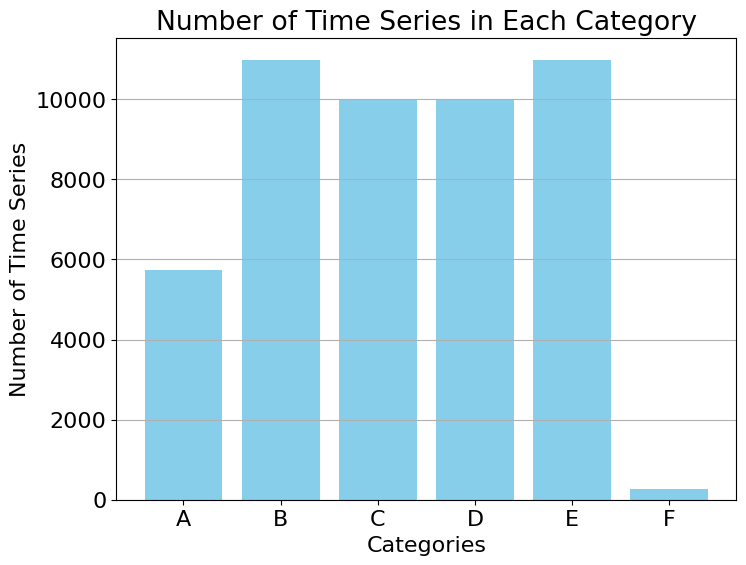

48000
[5728, 10987, 10017, 10016, 10975, 277]


In [9]:
quick_counter = 0
n_samples_cat = []
for category in ['A', 'B', 'C', 'D', 'E', 'F']:
    num_cat = len(categorized_series[category])
    quick_counter += num_cat
    print(f'There are {num_cat} time series of category {category}')
    n_samples_cat.append(num_cat)
    
categories = ['A', 'B', 'C', 'D', 'E', 'F']
num_time_series = [len(categorized_series[category]) for category in categories]

plt.figure(figsize=(8, 6))
plt.bar(categories, num_time_series, color='skyblue')
plt.xlabel('Categories')
plt.ylabel('Number of Time Series')
plt.title('Number of Time Series in Each Category')
plt.grid(axis='y')
plt.show()
    
print(quick_counter) # Check if everything's fine
print(n_samples_cat)

In [10]:
# Access the first 10 elements of each category
first_10_elements = {category: categorized_series[category][:10] for category in categorized_series}

# Print the first 10 elements of each category along with their lengths
for category, elements in first_10_elements.items():
    print(f"Category {category}:")
    for idx, element in enumerate(elements, start=1):
        print(f"Element {idx}: Length - {len(element)}")
    print("\n")

Category A:
Element 1: Length - 240
Element 2: Length - 168
Element 3: Length - 168
Element 4: Length - 168
Element 5: Length - 168
Element 6: Length - 168
Element 7: Length - 168
Element 8: Length - 168
Element 9: Length - 168
Element 10: Length - 168


Category B:
Element 1: Length - 336
Element 2: Length - 336
Element 3: Length - 517
Element 4: Length - 364
Element 5: Length - 397
Element 6: Length - 493
Element 7: Length - 300
Element 8: Length - 492
Element 9: Length - 359
Element 10: Length - 660


Category C:
Element 1: Length - 431
Element 2: Length - 168
Element 3: Length - 900
Element 4: Length - 94
Element 5: Length - 94
Element 6: Length - 804
Element 7: Length - 804
Element 8: Length - 804
Element 9: Length - 504
Element 10: Length - 288


Category D:
Element 1: Length - 451
Element 2: Length - 451
Element 3: Length - 451
Element 4: Length - 64
Element 5: Length - 94
Element 6: Length - 648
Element 7: Length - 94
Element 8: Length - 94
Element 9: Length - 804
Element 10: L

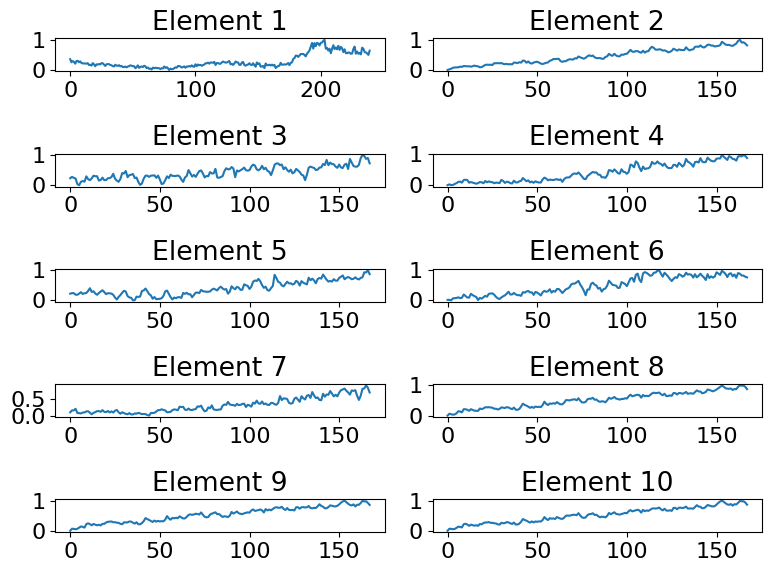

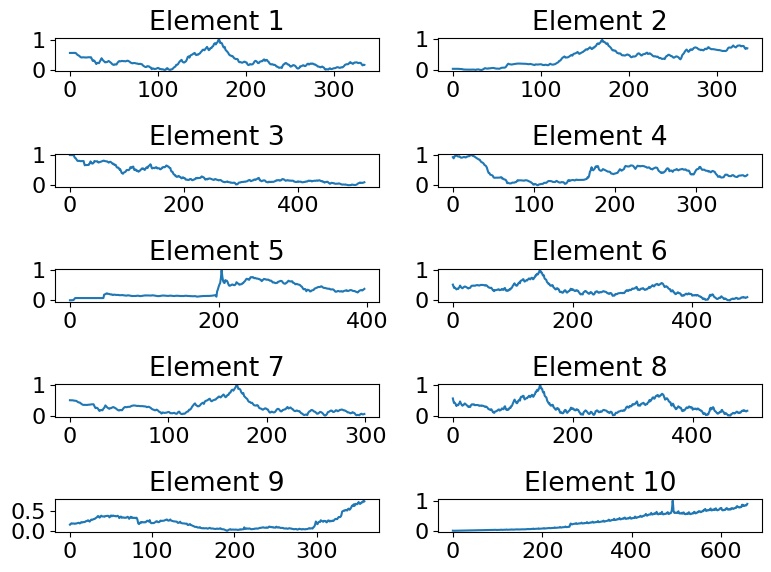

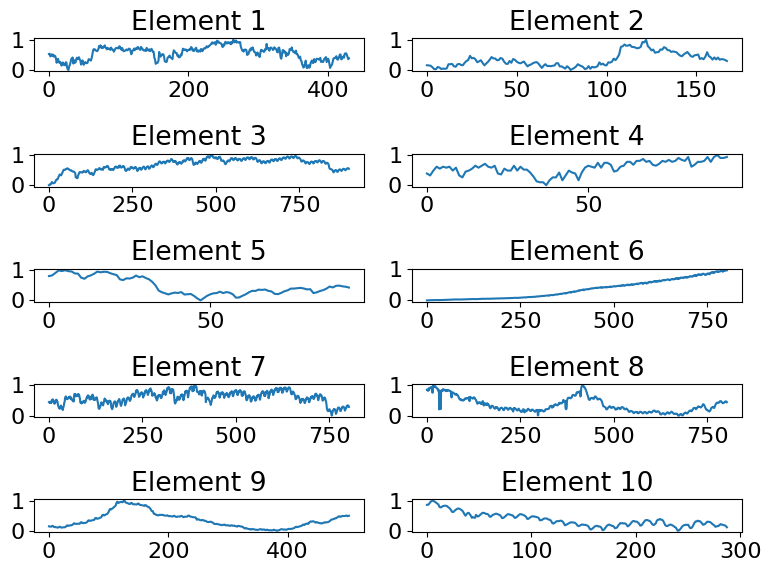

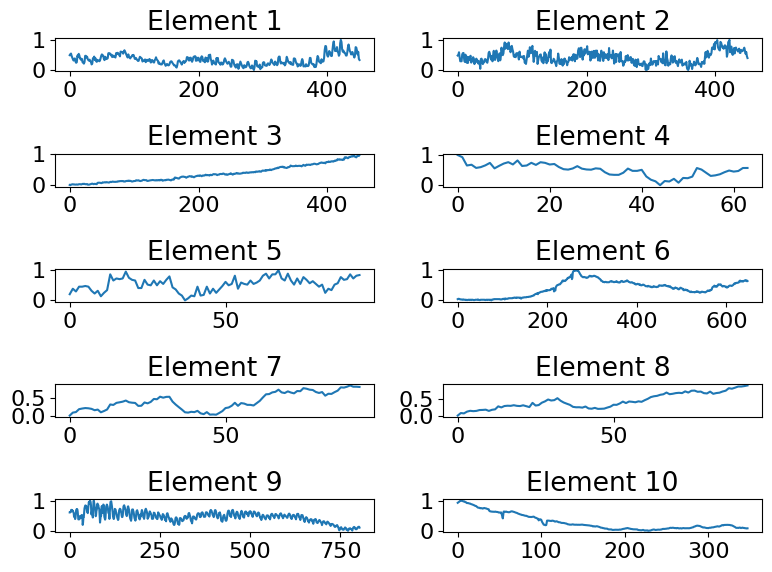

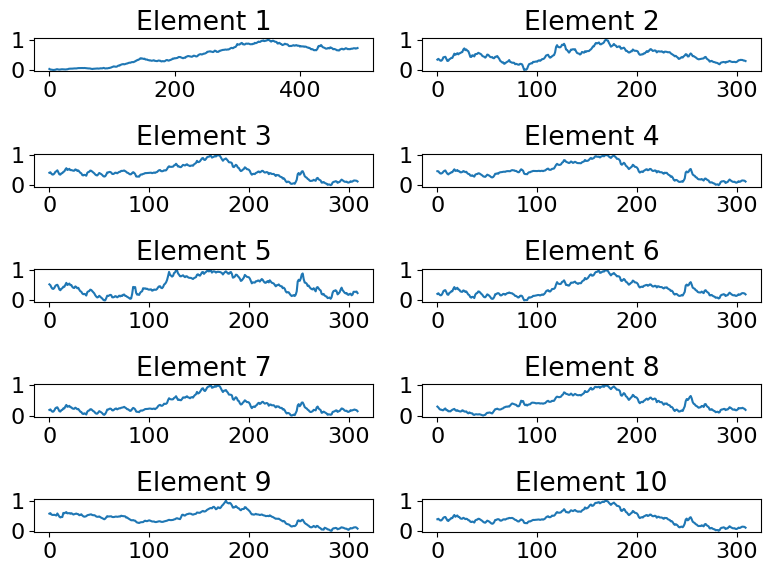

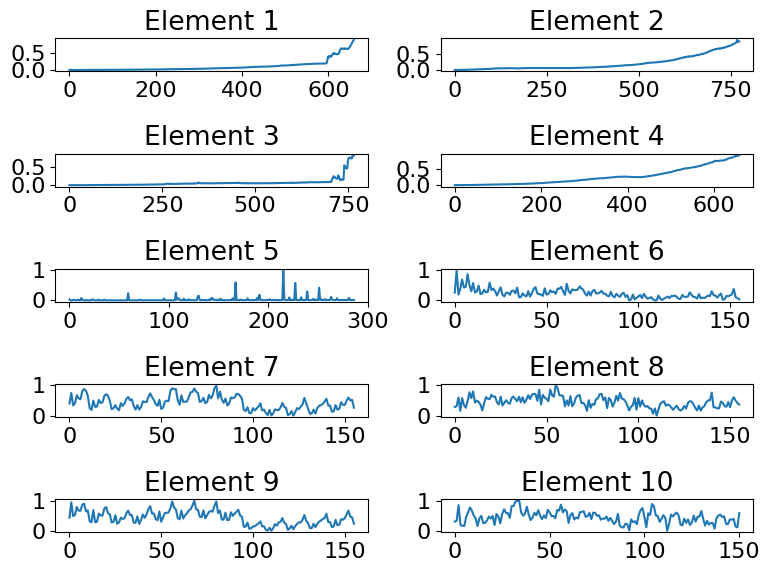

In [11]:
# Plot the first 10 elements of each category on different figures
for category, elements in categorized_series.items():
    plt.figure(figsize=(8, 6))
    plt.title(f"Category {category}")
    
    for idx, element in enumerate(elements[:10], start=1):
        plt.subplot(5, 2, idx)  # Create subplots for each element
        plt.plot(element)
        plt.title(f"Element {idx}")
    
    plt.tight_layout()
    plt.show()

# DLINEAR


In [12]:
from sklearn.model_selection import train_test_split

all_train_data = []
all_test_data = []
all_val_data = []

for category_data in [categorized_series['A'], categorized_series['B'], categorized_series['C'], categorized_series['D'], categorized_series['E'], categorized_series['F']]:  # Add other categories as needed
    # Perform train-test-validation split for each category
    train_data, val_data = train_test_split(category_data, test_size=0.25, shuffle=True , random_state=2)
    #test_data, val_data = train_test_split(test_val_data, test_size=0.2, shuffle=True)  # Split the remaining for test and val
    
    # Append data from each category to the respective lists
    all_train_data.extend(train_data)
    # all_test_data.extend(test_data)
    all_val_data.extend(val_data)

In [13]:
sequence_length = 200

np.random.shuffle(all_train_data)
np.random.shuffle(all_val_data)
#np.random.shuffle(all_test_data)

def create_sequences(data):
    input_sequences = []
    output_sequences = []
    for series in data:
        for i in range(len(series) - sequence_length - 9):  # Considering 9 samples as the prediction horizon
            input_sequences.append(series[i:i + sequence_length])
            output_sequences.append(series[i + sequence_length:i + sequence_length + 9])
    return np.array(input_sequences), np.array(output_sequences)

# Create input-output sequences for training, validation, and testing data
train_input, train_output = create_sequences(all_train_data)
val_input, val_output = create_sequences(all_val_data)
#test_input, test_output = create_sequences(all_test_data)

# Reshape data for RNN input (assuming 3D input shape [samples, time steps, features])
train_input = train_input.reshape(train_input.shape[0], sequence_length)
val_input = val_input.reshape(val_input.shape[0], sequence_length)
#test_input = test_input.reshape(test_input.shape[0], sequence_length)

In [14]:
from tensorflow import keras

from keras import regularizers
from tensorflow.keras.layers import MultiHeadAttention, Dropout, LayerNormalization

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Conv1D, GlobalAveragePooling1D, Concatenate, MaxPooling1D

import tensorflow as tf
import numpy as np

# BUILDING A MOVING AVARAGE FILTER (DENOISING)


This can be done either using a convolutional layer as the one described here below or using an AvaragePooling layer. Note that padding=causal preserves both the last partof the signal and the length of the signal

- Application of denoising filter

In [41]:
import keras.backend as K
from keras.models import Model
# custom filter
def my_filter(shape, window=20, dtype=None):


    f = np.array([
            [[1/window]] for i in range(window)]
        )
    print(shape)
    assert f.shape == shape
    return K.variable(f, dtype='float32')

In [42]:
def denoising_model():
    input_tensor = tfkl.Input(shape=(None,1))

    x = tfkl.Conv1D(filters=1, 
                      kernel_size = 20,
                      kernel_initializer=my_filter,
                      strides=1, 
                      padding='causal') (input_tensor)

    model = Model(inputs=input_tensor, outputs=x)
    return model

(20, 1, 1)
1/1 [==============================] - 0s 53ms/step
(1, 200, 1)


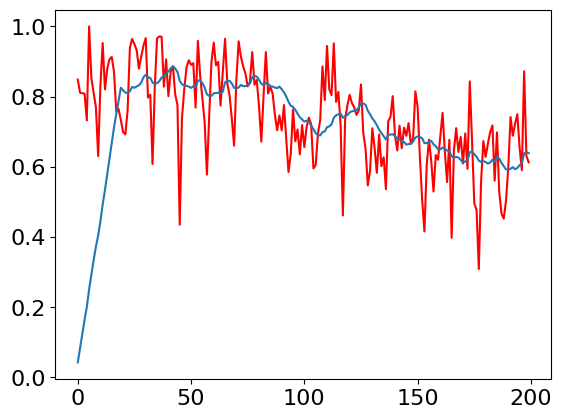

In [43]:
model = denoising_model()
out = model.predict(train_input[0].reshape(1,train_input[0].shape[0]))
print(out.shape)
plt.plot(train_input[0], color='red')
plt.plot(out[0])


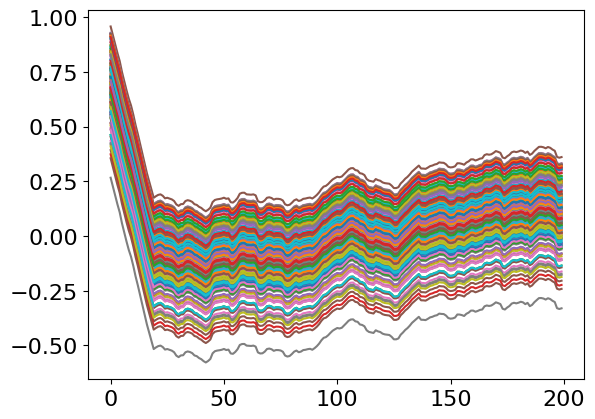

In [49]:
plt.plot(train_input[0]-out[0])

In [18]:
layer= tfkl.Conv1D(filters=1, kernel_size = 25,kernel_initializer=my_filter,strides=1, padding='same')
layer.trainable=False

# DLinear

- split trend and seasonal part by means of a denoising filter
- predict them using two different linear models
- combine the predictions

In [ ]:
def build_Dlinear():
    
    
    input_layer=tfkl.Input(shape=(200,1))
    
    # moving avarage to extract trend
    
    trend=tfkl.Conv1D(filters=1, kernel_size = 20,kernel_initializer=my_filter,strides=1, padding='causal')(input_layer)
    trend.trainable=False
    
    # seasonality
    
    seas=input_layer-trend
    
    # predictions
    trend = tf.squeeze(trend, axis=-1)
    seas = tf.squeeze(seas, axis=-1)
   

    hidden_trend=Dense(256)(trend)
    hidden_seas=Dense(256)(seas)

    trend_pred=Dense(9 , activation="linear")(hidden_trend)
    
    seas_pred=Dense(9 , activation="linear")(hidden_seas)
  
    final_pred=trend_pred+seas_pred
    
    model = Model(inputs=input_layer, outputs=final_pred)
    return model
    
    
model=build_Dlinear()

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Print model summary
model.summary()

In [1]:
model.fit(train_input, train_output, epochs=15, batch_size=128, validation_data=(val_input, val_output), callbacks=[tfk.callbacks.EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True),
                                                                                                                     tfk.callbacks.ReduceLROnPlateau(monitor='val_loss', patience=2, factor=0.6, min_lr=1e-5)])

# Nlinear

- subtract the last element to the time series

- predict the resulting time series by means of a linear model

- add the last element to the time seires

In [67]:
def build_Nlinear():
    
    
    input_layer=tfkl.Input(shape=(200,1))
    
    last_el=input_layer[-1][-1]
    
    subtracted=input_layer-last_el
    
    subtracted = tf.squeeze(subtracted, axis=-1)

   

    pred=Dense(9 , activation="linear")(subtracted)
    

  
    final_pred=pred+last_el
    
    model = Model(inputs=input_layer, outputs=final_pred)
    return model
    
    
model=build_Nlinear()

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Print model summary
model.summary()

Model: "model_19"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_27 (InputLayer)       [(None, 200, 1)]             0         []                            
                                                                                                  
 tf.__operators__.getitem_1  (200, 1)                     0         ['input_27[0][0]']            
 0 (SlicingOpLambda)                                                                              
                                                                                                  
 tf.__operators__.getitem_1  (1,)                         0         ['tf.__operators__.getitem_10[
 1 (SlicingOpLambda)                                                0][0]']                       
                                                                                           

In [68]:
model.fit(train_input, train_output, epochs=10, batch_size=128, validation_data=(val_input, val_output), callbacks=[tfk.callbacks.EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True),
                                                                                                                     tfk.callbacks.ReduceLROnPlateau(monitor='val_loss', patience=5, factor=0.5, min_lr=1e-5)])

Epoch 1/10
13771/13771 [==============================] - 39s 3ms/step - loss: 0.0081 - val_loss: 0.0074 - lr: 0.0010
Epoch 2/10
13771/13771 [==============================] - 37s 3ms/step - loss: 0.0068 - val_loss: 0.0063 - lr: 0.0010
Epoch 3/10
13771/13771 [==============================] - 37s 3ms/step - loss: 0.0068 - val_loss: 0.0067 - lr: 0.0010
Epoch 4/10
13771/13771 [==============================] - 38s 3ms/step - loss: 0.0068 - val_loss: 0.0064 - lr: 0.0010
Epoch 5/10
13771/13771 [==============================] - 37s 3ms/step - loss: 0.0068 - val_loss: 0.0066 - lr: 0.0010
Epoch 6/10
13771/13771 [==============================] - 37s 3ms/step - loss: 0.0067 - val_loss: 0.0062 - lr: 0.0010
Epoch 7/10
13771/13771 [==============================] - 37s 3ms/step - loss: 0.0067 - val_loss: 0.0064 - lr: 0.0010
Epoch 8/10
13771/13771 [==============================] - 38s 3ms/step - loss: 0.0065 - val_loss: 0.0063 - lr: 5.0000e-04
Epoch 9/10
13771/13771 [============================